# Titanic: Machine Learning from Disaster

## Data Overview

| Variable                   | Definition                 | Key                        |
|----------------------------|:--------------------------:|---------------------------:|
|     survival               |     Survival               |     0 = No, 1 = Yes           |
|     pclass                 |     Ticket Class           |     1 = 1st, 2 = 2nd, 3 = 3rd | 
|     sex                    |     Sex                    |                            |
|     Age                    |     Age in years           |                            |
|     sibsp                  |     # of siblings / spouses aboard the Titanic  |          |
|     parch                  |     # of parents / children aboard the Titanic  |          |
|     ticket                 |     Ticket number          |                            |
|     fare                   |     Passanger fare         |                            |
|     cabin                  |     Cabin number           |                            |
|     embarked               |     Port of embarkation    |     C = Cherbourg, Q = Queenstown, S = Southampton|

### Variable Notes

+ **pclass**: Proxy for social status
    - 1st = Upper
    - 2nd = Middle
    - 3rd = Lower


+ **age**: Age is fictional if less than 1. if the age is estimated, is it in the form of xx.5


+ **sibsp**: The dataset defines family relations in this way...
    - Sibling = brother, sister, stepbrother, stepsister
    - Spouse = husband, wife (mistresses and fiancés were ignored)


+ **parch**: The dataset defines family relations in this way...
    - Parent = mother, father
    - Child = daughter, son, stepdaughter, stepson
    - Some children travelled only with a nanny, therefore parch=0 for them.

In [1]:
import pandas as pd
import numpy as np
import scipy as sp

import re
import sklearn

from statsmodels.graphics.mosaicplot import mosaic

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

In [2]:
X_test = pd.read_csv('data/test.csv')
y_test = pd.read_csv('data/gender_submission.csv')
train = pd.read_csv('data/train.csv')

In [3]:
test = pd.merge(X_test, y_test, on='PassengerId', how='left')

In [4]:
df = pd.concat([train, test]).set_index('PassengerId', drop=True).sort_index()

In [5]:
missing_count = pd.DataFrame({'nulls': train.isnull().sum(), 'not_nulls': train.notnull().sum()})
missing_count['Total'] = missing_count.nulls + missing_count.not_nulls

In [6]:
missing_count

,not_nulls,nulls,Total
PassengerId,891,0,891
Survived,891,0,891
Pclass,891,0,891
Name,891,0,891
Sex,891,0,891
Age,714,177,891
SibSp,891,0,891
Parch,891,0,891
Ticket,891,0,891
Fare,891,0,891


In [7]:
df['Title'] = df.Name.replace('(.*, )|(\\..*)', '', regex=True)

In [8]:
rare_title = ['Dona', 'Lady', 'the Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer']

In [9]:
df.Title = df.Title.replace(['Ms', 'Mlle'], 'Miss')
df.Title = df.Title.replace('Mme', 'Mrs')
df.Title = df.Title.replace(rare_title, 'Rare')

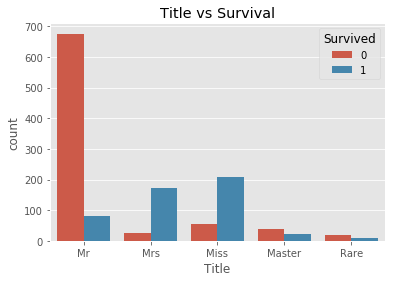

In [10]:
sns.countplot('Title',hue='Survived',data=df)
plt.title('Title vs Survival')
plt.show()

In [11]:
df['Surname'] = df.Name.apply(lambda x: re.split("[,.]", x)[0])

In [12]:
# Family size variable including the passenger themselves
df['f_size'] = df.SibSp + df.Parch + 1

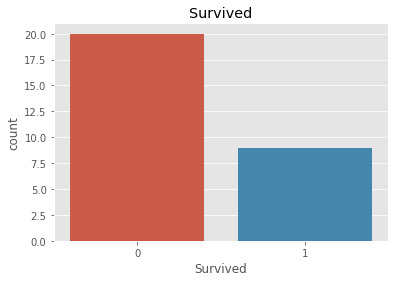

In [13]:
sns.countplot('Survived',data=df[df['Title'] == 'Rare']).set_title('Survived')
plt.show()

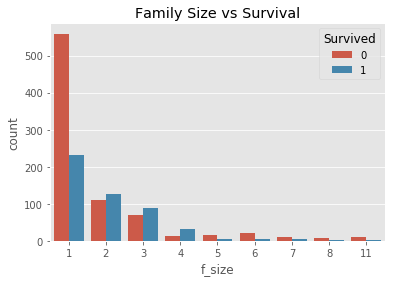

In [14]:
sns.countplot('f_size',hue='Survived',data=df)
plt.title('Family Size vs Survival')
plt.show()

More deaths for singletons and families with more than 4 elements. 2, 3 or 4 element famillies seem to have higher possibility of survival.

Let us colapse this into 3 levels, since there are less large families

In [15]:
df.loc[df['f_size'] == 1, 'f_size_class'] = 'singleton'
df.loc[df['f_size'] > 4, 'f_size_class'] = 'large'
df['f_size_class'].fillna('small', inplace = True)

In [16]:
pd.crosstab(index = df["Sex"], columns=df["Title"])

Title,Master,Miss,Mr,Mrs,Rare
Sex,,,,,
female,0,264,0,198,4
male,61,0,757,0,25


## Lets Take a look at the 'Cabin' feature

In [17]:
df['HasCabin'] = df["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

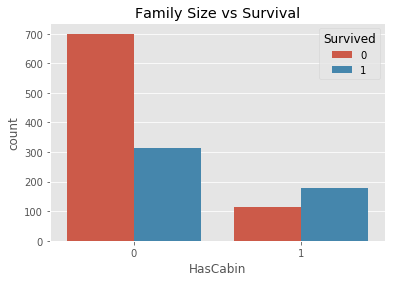

In [18]:
sns.countplot('HasCabin',hue='Survived',data=df)
plt.title('Family Size vs Survival')
plt.show()

In [19]:
df['Deck'] = df['Cabin'].apply(lambda x: str(x).split()[0][0] if x!=np.nan else np.nan).replace('n', np.nan)

In [20]:
df.loc[df.Cabin.notnull(),'nr_of_rooms'] = df.loc[df.Cabin.notnull(),'Cabin'].apply(lambda x: len(x.split()))

## Lets take care of Missing Values

In [22]:
missing_count

,not_nulls,nulls,Total
PassengerId,891,0,891
Survived,891,0,891
Pclass,891,0,891
Name,891,0,891
Sex,891,0,891
Age,714,177,891
SibSp,891,0,891
Parch,891,0,891
Ticket,891,0,891
Fare,891,0,891


### Embarked

In [25]:
df[df.Embarked.isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,Title,Surname,f_size,f_size_class,HasCabin,Deck,nr_of_rooms
PassengerId,,,,,,,,,,,,,,,,,,
62,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,1,female,0,1,113572,Miss,Icard,1,singleton,1,B,1.0
830,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,1,female,0,1,113572,Mrs,Stone,1,singleton,1,B,1.0


Both missing values refer to Passegers that paid 80 dollars, both female, both survived, both alone, both had one room on deck B and class 1

In [38]:
df[(df.Pclass==1) & (df.Deck=='B')].Embarked.mode()

0    C
dtype: object

Most likely both embarked from C

In [43]:
df.loc[[62, 830], 'Embarked'] = 'C'

In [47]:
missing_count = pd.DataFrame({'nulls': df.isnull().sum(), 'not_nulls': df.notnull().sum()})
missing_count['Total'] = missing_count.nulls + missing_count.not_nulls

### Fare

In [50]:
df[df['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,Title,Surname,f_size,f_size_class,HasCabin,Deck,nr_of_rooms
PassengerId,,,,,,,,,,,,,,,,,,
1044,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,3,male,0,0,3701,Mr,Storey,1,singleton,0,NaN,NaN


In [55]:
df[(df.Pclass==3) & (df.Embarked=='S') & (df.f_size_class == 'singleton')].Fare.median()

7.8958

In [56]:
df.loc[1044, 'Fare'] = 7.8958

### Age